In [1]:
# import required libraries
import numpy as np
import pandas as pd

import pandas_datareader as pdr
import yfinance as yf

import statsmodels.api as sm
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt

In [2]:
# Download the data
factors = pdr.get_data_famafrench(
    'F-F_Research_Data_Factors',
    start = '2000-01-01'
)[0][1:]

SMB = factors.SMB
HML = factors.HML

In [3]:
data = yf.download(
    ['SPY', 'MSFT', 'AAPL', 'INTC'], 
    start="2000-01-01", 
    interval="1mo"
)['Adj Close']

monthly_returns = data.pct_change().to_period("M")

[*********************100%***********************]  4 of 4 completed


In [4]:
bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis=1)
active = R - bench

In [5]:
df = pd.DataFrame({
    'R': active,
    'F1': SMB,
    'F2': HML,
}).dropna()

b1, b2 = regression.linear_model.OLS(
    df.R, 
    df[['F1', 'F2']]
).fit().params

print(f'Sensitivities of active returns to factors:\nSMB: {b1}\nHML: {b2}')


Sensitivities of active returns to factors:
SMB: 0.002372008673315294
HML: -0.0055782758524318375


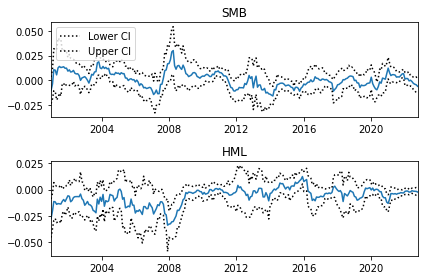

In [6]:
exog_vars = ["SMB", "HML"]
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(df.R, exog, window=12)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=exog_vars)

# Save the figure.
plt.savefig("./Images/SMB_HML.jpg")

In [7]:
F1 = df.F1
F2 = df.F2

cov = np.cov(F1, F2)
ar_squared = (active.std())**2
mcar1 = (b1 * (b2 * cov[0,1] + b1 * cov[0,0])) / ar_squared
mcar2 = (b2 * (b1 * cov[0,1] + b2 * cov[1,1])) / ar_squared
print (f'SMB risk contribution: {mcar1}')
print (f'HML risk contribution: {mcar2}')
print (f'Unexplained risk contribution: {1 - (mcar1 + mcar2)}')


SMB risk contribution: 0.026341813660628592
HML risk contribution: 0.12449724906199232
Unexplained risk contribution: 0.8491609372773791
